In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from collections import Counter
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from sqlalchemy import create_engine
import psycopg2
import datetime

### Read data from csv

In [56]:
# Read indexProcessed.csv
df = pd.read_csv('Data/indexProcessed.csv')
df.dtypes

Index         object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
CloseUSD     float64
dtype: object

In [57]:
# Read indexInfo.csv
df_ref = pd.read_csv('Data/indexInfo.csv')
df_ref.dtypes

Region      object
Exchange    object
Index       object
Currency    object
dtype: object

In [58]:
# Merged DF 
Merged_df = pd.merge(df_ref,df, how='inner')
Merged_df.head(3)

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,United States,New York Stock Exchange,NYA,USD,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,528.690002
1,United States,New York Stock Exchange,NYA,USD,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022
2,United States,New York Stock Exchange,NYA,USD,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027


### DF for IXIC

In [59]:
# Dataframe for NYA

df_IXIC = Merged_df[Merged_df['Index'] == 'IXIC']
df_IXIC.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
13947,United States,NASDAQ,IXIC,USD,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0.0,100.000000
13948,United States,NASDAQ,IXIC,USD,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0.0,100.839996
13949,United States,NASDAQ,IXIC,USD,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0.0,100.760002
13950,United States,NASDAQ,IXIC,USD,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0.0,100.690002
13951,United States,NASDAQ,IXIC,USD,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0.0,101.449997


### Update Date datatype

In [60]:
df_IXIC["Date"] = pd.to_datetime(df_IXIC["Date"])
df_IXIC.dtypes

/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Region               object
Exchange             object
Index                object
Currency             object
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
CloseUSD            float64
dtype: object

### add prev day close, high, low to todays row

In [61]:
for i in range(df_IXIC.index[0], df_IXIC.index[-1]):
    
    try: 
        
        df_IXIC.loc[i,'PrevClose'] = df_IXIC.loc[i-1,'Close']
        df_IXIC.loc[i,'PrevHigh'] = df_IXIC.loc[i-1,'High']
        df_IXIC.loc[i,'PrevLow'] = df_IXIC.loc[i-1,'Low']
    
    except:
        print("Index not found")
    
df_IXIC.head()

Index not found


/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow
13947,United States,NASDAQ,IXIC,USD,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0.0,100.000000,NaN,NaN,NaN
13948,United States,NASDAQ,IXIC,USD,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0.0,100.839996,100.000000,100.000000,100.000000
13949,United States,NASDAQ,IXIC,USD,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0.0,100.760002,100.839996,100.839996,100.839996
13950,United States,NASDAQ,IXIC,USD,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0.0,100.690002,100.760002,100.760002,100.760002
13951,United States,NASDAQ,IXIC,USD,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0.0,101.449997,100.690002,100.690002,100.690002


### create target

In [62]:
# Find delta of today's close price from yesterday's close price 

df_IXIC['Delta'] = df_IXIC['Close'].diff(periods=1)
df_IXIC.head()

/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta
13947,United States,NASDAQ,IXIC,USD,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0.0,100.000000,NaN,NaN,NaN,NaN
13948,United States,NASDAQ,IXIC,USD,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0.0,100.839996,100.000000,100.000000,100.000000,0.839996
13949,United States,NASDAQ,IXIC,USD,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0.0,100.760002,100.839996,100.839996,100.839996,-0.079994
13950,United States,NASDAQ,IXIC,USD,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0.0,100.690002,100.760002,100.760002,100.760002,-0.070000
13951,United States,NASDAQ,IXIC,USD,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0.0,101.449997,100.690002,100.690002,100.690002,0.759995


In [63]:
#  Add traget column to dataframe

df_IXIC['Target'] = np.where(df_IXIC['Delta']>=0, 'Up', 'Down')
df_IXIC.head()

/Users/michalmichael/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Target
13947,United States,NASDAQ,IXIC,USD,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0.0,100.000000,NaN,NaN,NaN,NaN,Down
13948,United States,NASDAQ,IXIC,USD,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0.0,100.839996,100.000000,100.000000,100.000000,0.839996,Up
13949,United States,NASDAQ,IXIC,USD,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0.0,100.760002,100.839996,100.839996,100.839996,-0.079994,Down
13950,United States,NASDAQ,IXIC,USD,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0.0,100.690002,100.760002,100.760002,100.760002,-0.070000,Down
13951,United States,NASDAQ,IXIC,USD,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0.0,101.449997,100.690002,100.690002,100.690002,0.759995,Up


In [64]:
# drop NaN
df_IXIC = df_IXIC.dropna(how="any")
df_IXIC.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Target
13948,United States,NASDAQ,IXIC,USD,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0.0,100.839996,100.000000,100.000000,100.000000,0.839996,Up
13949,United States,NASDAQ,IXIC,USD,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0.0,100.760002,100.839996,100.839996,100.839996,-0.079994,Down
13950,United States,NASDAQ,IXIC,USD,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0.0,100.690002,100.760002,100.760002,100.760002,-0.070000,Down
13951,United States,NASDAQ,IXIC,USD,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0.0,101.449997,100.690002,100.690002,100.690002,0.759995,Up
13952,United States,NASDAQ,IXIC,USD,1971-02-12,102.050003,102.050003,102.050003,102.050003,102.050003,0.0,102.050003,101.449997,101.449997,101.449997,0.600006,Up


In [65]:
df_IXIC.isnull().sum()

Region       0
Exchange     0
Index        0
Currency     0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
CloseUSD     0
PrevClose    0
PrevHigh     0
PrevLow      0
Delta        0
Target       0
dtype: int64

In [66]:
list(df_IXIC)

['Region',
 'Exchange',
 'Index',
 'Currency',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'CloseUSD',
 'PrevClose',
 'PrevHigh',
 'PrevLow',
 'Delta',
 'Target']

### logistic regression

In [67]:
from sklearn.linear_model import LogisticRegression

y = df_IXIC['Target']
X = df_IXIC[['Open',
 'PrevHigh',
 'PrevLow',
 'PrevClose'
           ]]

clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X)

clf.predict_proba(X)

clf.score(X, y)

0.6202711223203027

### split data into training and testing

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, = train_test_split (X,
                                                     y,
                                                     random_state =1,
                                                     stratify = y)

X_train.shape
Counter(y_train)

Counter({'Down': 4174, 'Up': 5342})

### random forest classifier

In [69]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Create a random forest classifier.
model = BalancedRandomForestClassifier(n_estimators=100, random_state=1) 

# Fitting the model
model = model.fit(X_train, y_train)

In [70]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.6367812895202213

In [71]:
len(y_pred)

3172

In [72]:
# create an acutal and predicted df
RFC_pred_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test})
RFC_pred_df.head()

,Prediction,Actual
19681,Up,Up
22183,Down,Down
14682,Up,Up
23701,Up,Down
25338,Down,Down


In [73]:
# merge test predictions with intitial df for comparison
RFC_df = RFC_pred_df.merge(df_IXIC, left_index=True, right_index=True)
RFC_df = RFC_df[['Region', 'Exchange', 'Index', 'Currency',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'CloseUSD', 'PrevClose', 'PrevHigh', 'PrevLow', 'Delta', 'Target', 'Actual','Prediction']]
RFC_df.drop('Target', axis=1, inplace=True)
RFC_df['Date'] =  pd.to_datetime(RFC_df['Date'])
RFC_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction
19681,United States,NASDAQ,IXIC,USD,1993-10-14,782.270020,785.950012,780.280029,785.409973,785.409973,3.827500e+08,785.409973,778.969971,779.010010,774.200012,6.440002,Up,Up
22183,United States,NASDAQ,IXIC,USD,2003-09-19,1913.739990,1913.739990,1895.930054,1905.699951,1905.699951,1.885000e+09,1905.699951,1909.550049,1910.510010,1874.300049,-3.850098,Down,Down
14682,United States,NASDAQ,IXIC,USD,1974-01-07,94.470001,94.470001,94.470001,94.470001,94.470001,0.000000e+00,94.470001,94.099998,94.099998,94.099998,0.370003,Up,Up
23701,United States,NASDAQ,IXIC,USD,2009-09-30,2131.300049,2137.870117,2092.300049,2122.419922,2122.419922,2.640660e+09,2122.419922,2124.040039,2141.399902,2116.629883,-1.620117,Down,Up
25338,United States,NASDAQ,IXIC,USD,2016-04-04,4911.209961,4917.750000,4885.169922,4891.799805,4891.799805,1.705730e+09,4891.799805,4914.540039,4917.089844,4832.060059,-22.740234,Down,Down


In [74]:
# export as csv
RFC_df.to_csv('Data/data_2/Random_Forest_Predictions_IXIC_2.csv')

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
RFC_plot_df = RFC_df
RFC_plot_df['Encoded'] = RFC_plot_df['Prediction'].map({'Up':1, 'Down':0})
RFC_plot_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction,Encoded
19681,United States,NASDAQ,IXIC,USD,1993-10-14,782.270020,785.950012,780.280029,785.409973,785.409973,3.827500e+08,785.409973,778.969971,779.010010,774.200012,6.440002,Up,Up,1
22183,United States,NASDAQ,IXIC,USD,2003-09-19,1913.739990,1913.739990,1895.930054,1905.699951,1905.699951,1.885000e+09,1905.699951,1909.550049,1910.510010,1874.300049,-3.850098,Down,Down,0
14682,United States,NASDAQ,IXIC,USD,1974-01-07,94.470001,94.470001,94.470001,94.470001,94.470001,0.000000e+00,94.470001,94.099998,94.099998,94.099998,0.370003,Up,Up,1
23701,United States,NASDAQ,IXIC,USD,2009-09-30,2131.300049,2137.870117,2092.300049,2122.419922,2122.419922,2.640660e+09,2122.419922,2124.040039,2141.399902,2116.629883,-1.620117,Down,Up,1
25338,United States,NASDAQ,IXIC,USD,2016-04-04,4911.209961,4917.750000,4885.169922,4891.799805,4891.799805,1.705730e+09,4891.799805,4914.540039,4917.089844,4832.060059,-22.740234,Down,Down,0


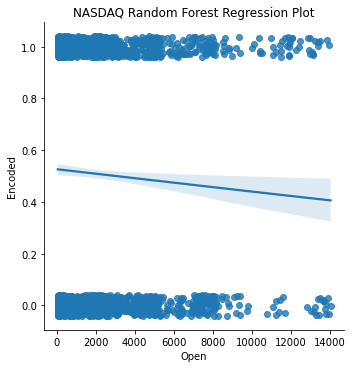

In [78]:
RFC_reg_plot = sns.lmplot(x="Open", y="Encoded", data=RFC_plot_df,
           logistic=True, y_jitter=.04);
RFC_reg_plot.set(title = 'NASDAQ Random Forest Regression Plot')

In [79]:
RFC_reg_plot.savefig('Plots/plots_2/NASDAQ_Random_Forest_Regression_2.png')

In [80]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)

array([[ 896,  495],
       [ 660, 1121]])

In [81]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Down       0.58      0.64      0.63      0.61      0.64      0.41      1391
         Up       0.69      0.63      0.64      0.66      0.64      0.40      1781

avg / total       0.64      0.64      0.64      0.64      0.64      0.41      3172



In [82]:
# List the features sorted in descending order by feature importance
sorted(zip(model.feature_importances_,X.columns), reverse=True)

[(0.3213535937095843, 'Open'),
 (0.22940721588993745, 'PrevClose'),
 (0.22497969471756107, 'PrevHigh'),
 (0.22425949568291714, 'PrevLow')]

### SMOTE

In [83]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample( X_train, y_train)

In [84]:
Counter(y_resampled)

Counter({'Down': 5342, 'Up': 5342})

In [85]:
# Train the Logistic Regression model using the resampled data
#from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [86]:
# Calculated the balanced accuracy score
#from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.7802951193018728

In [87]:
# create an acutal and predicted df
SRFC_pred_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test})
SRFC_pred_df.head()

,Prediction,Actual
19681,Up,Up
22183,Up,Down
14682,Up,Up
23701,Up,Down
25338,Down,Down


In [88]:
# merge test predictions with intitial df for comparison
SRFC_df = SRFC_pred_df.merge(df_IXIC, left_index=True, right_index=True)
SRFC_df = SRFC_df[['Region', 'Exchange', 'Index', 'Currency',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'CloseUSD', 'PrevClose', 'PrevHigh', 'PrevLow', 'Delta', 'Target', 'Actual','Prediction']]
SRFC_df.drop('Target', axis=1, inplace=True)
SRFC_df['Date'] =  pd.to_datetime(SRFC_df['Date'])
SRFC_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction
19681,United States,NASDAQ,IXIC,USD,1993-10-14,782.270020,785.950012,780.280029,785.409973,785.409973,3.827500e+08,785.409973,778.969971,779.010010,774.200012,6.440002,Up,Up
22183,United States,NASDAQ,IXIC,USD,2003-09-19,1913.739990,1913.739990,1895.930054,1905.699951,1905.699951,1.885000e+09,1905.699951,1909.550049,1910.510010,1874.300049,-3.850098,Down,Up
14682,United States,NASDAQ,IXIC,USD,1974-01-07,94.470001,94.470001,94.470001,94.470001,94.470001,0.000000e+00,94.470001,94.099998,94.099998,94.099998,0.370003,Up,Up
23701,United States,NASDAQ,IXIC,USD,2009-09-30,2131.300049,2137.870117,2092.300049,2122.419922,2122.419922,2.640660e+09,2122.419922,2124.040039,2141.399902,2116.629883,-1.620117,Down,Up
25338,United States,NASDAQ,IXIC,USD,2016-04-04,4911.209961,4917.750000,4885.169922,4891.799805,4891.799805,1.705730e+09,4891.799805,4914.540039,4917.089844,4832.060059,-22.740234,Down,Down


In [89]:
# export as csv
SRFC_df.to_csv('Data/data_2/SMOTE_Random_Forest_Predictions_IXIC_2.csv')

In [90]:
SRFC_plot_df = SRFC_df
SRFC_plot_df['Encoded'] = SRFC_plot_df['Prediction'].map({'Up':1, 'Down':0})
SRFC_plot_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction,Encoded
19681,United States,NASDAQ,IXIC,USD,1993-10-14,782.270020,785.950012,780.280029,785.409973,785.409973,3.827500e+08,785.409973,778.969971,779.010010,774.200012,6.440002,Up,Up,1
22183,United States,NASDAQ,IXIC,USD,2003-09-19,1913.739990,1913.739990,1895.930054,1905.699951,1905.699951,1.885000e+09,1905.699951,1909.550049,1910.510010,1874.300049,-3.850098,Down,Up,1
14682,United States,NASDAQ,IXIC,USD,1974-01-07,94.470001,94.470001,94.470001,94.470001,94.470001,0.000000e+00,94.470001,94.099998,94.099998,94.099998,0.370003,Up,Up,1
23701,United States,NASDAQ,IXIC,USD,2009-09-30,2131.300049,2137.870117,2092.300049,2122.419922,2122.419922,2.640660e+09,2122.419922,2124.040039,2141.399902,2116.629883,-1.620117,Down,Up,1
25338,United States,NASDAQ,IXIC,USD,2016-04-04,4911.209961,4917.750000,4885.169922,4891.799805,4891.799805,1.705730e+09,4891.799805,4914.540039,4917.089844,4832.060059,-22.740234,Down,Down,0


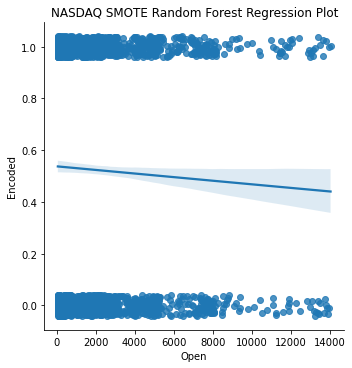

In [91]:
SRFC_reg_plot = sns.lmplot(x="Open", y="Encoded", data=SRFC_plot_df,
           logistic=True, y_jitter=.04);
SRFC_reg_plot.set(title = 'NASDAQ SMOTE Random Forest Regression Plot')

In [92]:
SRFC_reg_plot.savefig('Plots/plots_2/NASDAQ_SMOTE_Random_Forest_Regression_2.png')

In [93]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)

array([[1100,  291],
       [ 410, 1371]])

In [94]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Down       0.73      0.79      0.77      0.76      0.78      0.61      1391
         Up       0.82      0.77      0.79      0.80      0.78      0.61      1781

avg / total       0.78      0.78      0.78      0.78      0.78      0.61      3172



### undersampling

In [95]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'Down': 4174, 'Up': 4174})

In [96]:
# Train the Logistic Regression model using the resampled data
#from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [97]:
# Calculated the balanced accuracy score
#from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.7749479185798172

In [98]:
# create an acutal and predicted df
URFC_pred_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test})
URFC_pred_df.head()

,Prediction,Actual
19681,Up,Up
22183,Up,Down
14682,Up,Up
23701,Up,Down
25338,Down,Down


In [99]:
# merge test predictions with intitial df for comparison
URFC_df = URFC_pred_df.merge(df_IXIC, left_index=True, right_index=True)
URFC_df = URFC_df[['Region', 'Exchange', 'Index', 'Currency',
       'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'CloseUSD', 'PrevClose', 'PrevHigh', 'PrevLow', 'Delta', 'Target', 'Actual','Prediction']]
URFC_df.drop('Target', axis=1, inplace=True)
URFC_df['Date'] =  pd.to_datetime(URFC_df['Date'])
URFC_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction
19681,United States,NASDAQ,IXIC,USD,1993-10-14,782.270020,785.950012,780.280029,785.409973,785.409973,3.827500e+08,785.409973,778.969971,779.010010,774.200012,6.440002,Up,Up
22183,United States,NASDAQ,IXIC,USD,2003-09-19,1913.739990,1913.739990,1895.930054,1905.699951,1905.699951,1.885000e+09,1905.699951,1909.550049,1910.510010,1874.300049,-3.850098,Down,Up
14682,United States,NASDAQ,IXIC,USD,1974-01-07,94.470001,94.470001,94.470001,94.470001,94.470001,0.000000e+00,94.470001,94.099998,94.099998,94.099998,0.370003,Up,Up
23701,United States,NASDAQ,IXIC,USD,2009-09-30,2131.300049,2137.870117,2092.300049,2122.419922,2122.419922,2.640660e+09,2122.419922,2124.040039,2141.399902,2116.629883,-1.620117,Down,Up
25338,United States,NASDAQ,IXIC,USD,2016-04-04,4911.209961,4917.750000,4885.169922,4891.799805,4891.799805,1.705730e+09,4891.799805,4914.540039,4917.089844,4832.060059,-22.740234,Down,Down


In [100]:
# export as csv
URFC_df.to_csv('Data/data_2/Undersampling_Random_Forest_Predictions_IXIC_2.csv')

In [101]:
URFC_plot_df = URFC_df
URFC_plot_df['Encoded'] = URFC_plot_df['Prediction'].map({'Up':1, 'Down':0})
URFC_plot_df.head()

,Region,Exchange,Index,Currency,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,PrevClose,PrevHigh,PrevLow,Delta,Actual,Prediction,Encoded
19681,United States,NASDAQ,IXIC,USD,1993-10-14,782.270020,785.950012,780.280029,785.409973,785.409973,3.827500e+08,785.409973,778.969971,779.010010,774.200012,6.440002,Up,Up,1
22183,United States,NASDAQ,IXIC,USD,2003-09-19,1913.739990,1913.739990,1895.930054,1905.699951,1905.699951,1.885000e+09,1905.699951,1909.550049,1910.510010,1874.300049,-3.850098,Down,Up,1
14682,United States,NASDAQ,IXIC,USD,1974-01-07,94.470001,94.470001,94.470001,94.470001,94.470001,0.000000e+00,94.470001,94.099998,94.099998,94.099998,0.370003,Up,Up,1
23701,United States,NASDAQ,IXIC,USD,2009-09-30,2131.300049,2137.870117,2092.300049,2122.419922,2122.419922,2.640660e+09,2122.419922,2124.040039,2141.399902,2116.629883,-1.620117,Down,Up,1
25338,United States,NASDAQ,IXIC,USD,2016-04-04,4911.209961,4917.750000,4885.169922,4891.799805,4891.799805,1.705730e+09,4891.799805,4914.540039,4917.089844,4832.060059,-22.740234,Down,Down,0


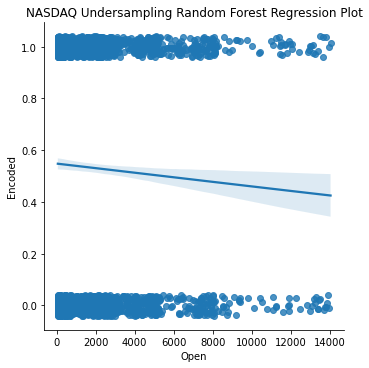

In [102]:
URFC_reg_plot = sns.lmplot(x="Open", y="Encoded", data=URFC_plot_df,
           logistic=True, y_jitter=.04);
URFC_reg_plot.set(title = 'NASDAQ Undersampling Random Forest Regression Plot')

In [103]:
SRFC_reg_plot.savefig('Plots/plots_2/NASDAQ_Undersampling_Random_Forest_Regression_2.png')

In [104]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)

array([[1082,  309],
       [ 406, 1375]])

In [105]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

       Down       0.73      0.78      0.77      0.75      0.77      0.60      1391
         Up       0.82      0.77      0.78      0.79      0.77      0.60      1781

avg / total       0.78      0.77      0.78      0.78      0.77      0.60      3172



### decision tree model

In [106]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [107]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [108]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [109]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

In [110]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

In [111]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [112]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [113]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,825,566
Actual 1,570,1211


Accuracy Score : 0.6418663303909206
Classification Report
              precision    recall  f1-score   support

        Down       0.59      0.59      0.59      1391
          Up       0.68      0.68      0.68      1781

    accuracy                           0.64      3172
   macro avg       0.64      0.64      0.64      3172
weighted avg       0.64      0.64      0.64      3172

